In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [4]:
df = pd.read_excel("Online Retail.xlsx")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
#counnt rows and columns of dataset
print(df.shape)

(541909, 8)


In [8]:
# Step 1: Data Preprocessing
#count duplicate values in dataset
df.duplicated().value_counts()

False    536641
True       5268
dtype: int64

In [9]:
df = df.drop_duplicates()


In [10]:
# Step 1: Data Preprocessing
# Filter out rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

In [11]:
# Remove transactions with negative or zero Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [12]:
# Create TotalSpending
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

In [13]:
# Cap extreme values for TotalSpending, Quantity, and UnitPrice
quantiles = df[['TotalSpending', 'Quantity', 'UnitPrice']].quantile(0.99)
df['TotalSpending'] = np.where(df['TotalSpending'] > quantiles['TotalSpending'], quantiles['TotalSpending'], df['TotalSpending'])
df['Quantity'] = np.where(df['Quantity'] > quantiles['Quantity'], quantiles['Quantity'], df['Quantity'])
df['UnitPrice'] = np.where(df['UnitPrice'] > quantiles['UnitPrice'], quantiles['UnitPrice'], df['UnitPrice'])

In [14]:
# Step 2: Feature Engineering
customer_data = df.groupby('CustomerID').agg(
    TotalSpending=('TotalSpending', 'sum'),
    AverageBasketSize=('Quantity', 'mean'),
    PurchaseFrequency=('InvoiceNo', 'nunique'),
    AverageSpendingPerInvoice=('TotalSpending', 'mean')
).reset_index()

In [15]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract additional features
df['Day'] = df['InvoiceDate'].dt.day
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year

In [16]:
# Step 3: Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalSpending', 'AverageBasketSize', 'PurchaseFrequency', 'AverageSpendingPerInvoice']])

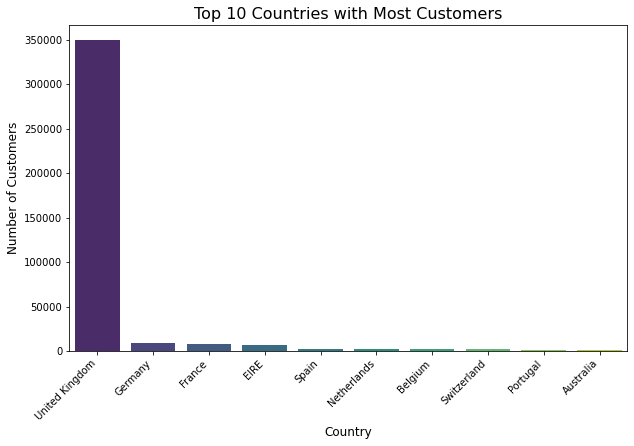

In [17]:
# 1. Plot: Most Customers from Multiple Countries (Top 10 Countries)
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")
plt.title('Top 10 Countries with Most Customers', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate country labels for better visibility
plt.show()

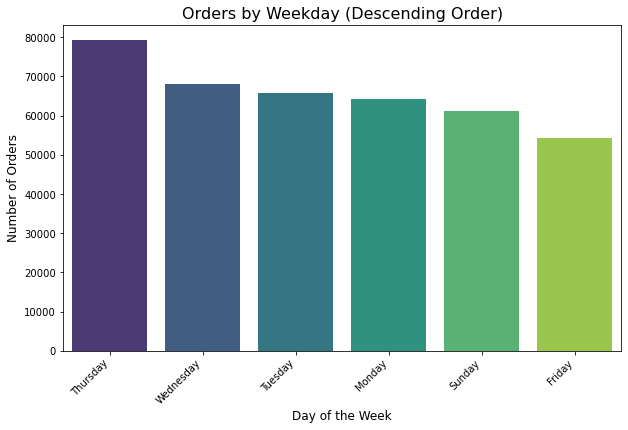

In [18]:
# 2. Plot: Orders by Weekday 

# Get the count of orders for each weekday
orders_by_weekday = df['InvoiceDate'].dt.day_name().value_counts()

# Sort the data in descending order
orders_by_weekday = orders_by_weekday.sort_values(ascending=False)

# Plotting the bar graph in the same style as the first plot
plt.figure(figsize=(10, 6))
sns.barplot(x=orders_by_weekday.index, y=orders_by_weekday.values, palette="viridis")
plt.title('Orders by Weekday (Descending Order)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate day labels for better visibility
plt.show()


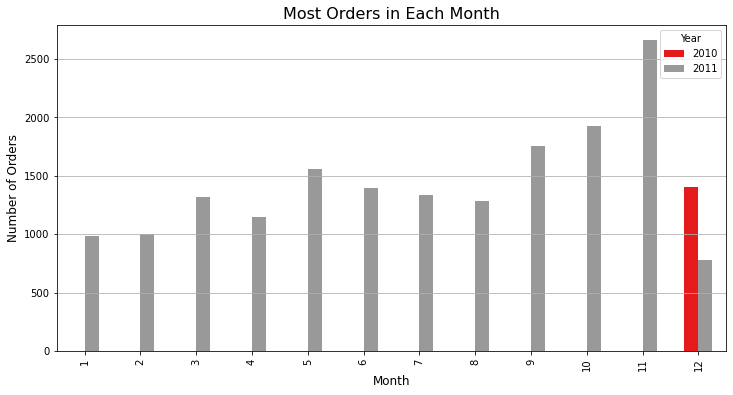

In [19]:
# 3. Plot: Most Orders in a Month
orders_by_month = df.groupby(['Year', 'Month'])['InvoiceNo'].nunique()
orders_by_month.unstack(level=0).plot(kind='bar', figsize=(12, 6), colormap='Set1')
plt.title('Most Orders in Each Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.legend(title='Year')
plt.grid(axis='y')
plt.show()

In [20]:
# Step 4a: K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['KMeansCluster'] = kmeans.fit_predict(scaled_data)


In [21]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
silhouette_kmeans = silhouette_score(scaled_data, customer_data['KMeansCluster'])
calinski_kmeans = calinski_harabasz_score(scaled_data, customer_data['KMeansCluster'])
davies_kmeans = davies_bouldin_score(scaled_data, customer_data['KMeansCluster'])

print("K-means Evaluation Metrics:")
print(f"Silhouette Score: {silhouette_kmeans:.3f}")
print(f"Calinski-Harabasz Index: {calinski_kmeans:.3f}")
print(f"Davies-Bouldin Index: {davies_kmeans:.3f}\n")

K-means Evaluation Metrics:
Silhouette Score: 0.782
Calinski-Harabasz Index: 2769.663
Davies-Bouldin Index: 0.761



In [22]:
dbscan = DBSCAN(eps=2.0, min_samples=3)
customer_data['DBSCANCluster'] = dbscan.fit_predict(scaled_data)

In [23]:
# Filter clusters (ignore noise points labeled as -1)
dbscan_clusters = customer_data[customer_data['DBSCANCluster'] != -1]

# Check if DBSCAN has produced meaningful clusters
unique_clusters = dbscan_clusters['DBSCANCluster'].nunique()
if unique_clusters > 1:
    # Evaluate DBSCAN
    silhouette_dbscan = silhouette_score(
        scaled_data[dbscan_clusters.index], dbscan_clusters['DBSCANCluster']
    )
    calinski_dbscan = calinski_harabasz_score(
        scaled_data[dbscan_clusters.index], dbscan_clusters['DBSCANCluster']
    )
    davies_dbscan = davies_bouldin_score(
        scaled_data[dbscan_clusters.index], dbscan_clusters['DBSCANCluster']
    )
    
    print("DBSCAN Evaluation Metrics:")
    print(f"Silhouette Score: {silhouette_dbscan:.3f}")
    print(f"Calinski-Harabasz Index: {calinski_dbscan:.3f}")
    print(f"Davies-Bouldin Index: {davies_dbscan:.3f}")
else:
    print("DBSCAN did not produce enough clusters for evaluation (less than 2 clusters).")


DBSCAN Evaluation Metrics:
Silhouette Score: 0.838
Calinski-Harabasz Index: 104.676
Davies-Bouldin Index: 0.176


In [24]:
# Step 5: Visualization
# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
customer_data['PCA1'] = reduced_data[:, 0]
customer_data['PCA2'] = reduced_data[:, 1]


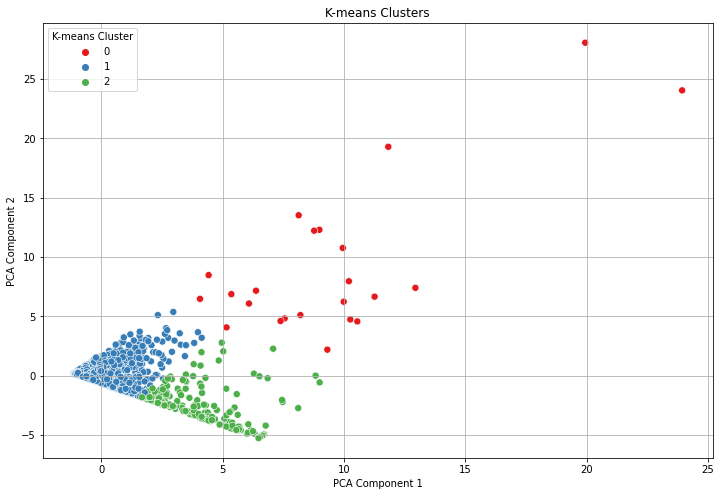

In [25]:
# Plot K-means clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='KMeansCluster', data=customer_data, palette='Set1', s=50
)
plt.title('K-means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='K-means Cluster')
plt.grid()
plt.show()

# INTREPRETATIONS

Cluster 0 (High-Value Customers):
Total Spending: $60,276.78
Average Basket Size: 44 items
Purchase Frequency: 70 purchases
Average Spending per Invoice: $74.86
Insight: This group consists of your most valuable customers, who spend the most and have a high frequency of purchases. They are likely repeat buyers, and their large basket size suggests they tend to buy in bulk. You could target this group for loyalty programs, exclusive offers, or personalized marketing campaigns to increase retention and further engagement.

Cluster 1 (Low-Value, Infrequent Buyers):
Total Spending: $1,344.09
Average Basket Size: 11 items
Purchase Frequency: 4 purchases
Average Spending per Invoice: $19.63
Insight: These customers spend relatively little and purchase infrequently. They might be occasional buyers or new customers. You could focus on trying to convert them into more frequent shoppers. Offering targeted promotions or discounts could help encourage more frequent purchases or higher spending per purchase.

Cluster 2 (Moderate Spend, High Basket Size):
Total Spending: $2,831.02
Average Basket Size: 72 items
Purchase Frequency: 5 purchases
Average Spending per Invoice: $136.29
Insight: This group has a moderately high spending level but with very large basket sizes. They may be buying a mix of items in each order but not as frequently as Cluster 0. Their average spending per invoice is quite high, indicating that while they don’t buy often, when they do, they tend to purchase many items. You could target this group with promotions on bulk buys or seasonal discounts to encourage larger purchases or increase purchase frequency.

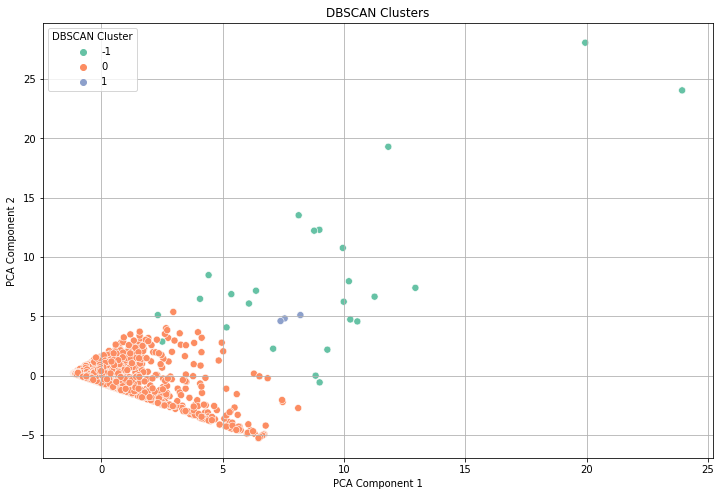

In [30]:
# Plot DBSCAN clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='DBSCANCluster', data=customer_data, palette='Set2', s=50
)
plt.title('DBSCAN Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='DBSCAN Cluster')
plt.grid()
plt.show()

# INTREPRETATIONS

Cluster 0 (Low-Value, Infrequent Buyers in DBSCAN)
Total Spending: $1,401.55
Average Basket Size: 14 items
Purchase Frequency: 4 purchases
Average Spending per Invoice: $25.61
PCA1: -0.06
PCA2: -0.05
Insight: Similar to K-means Cluster 1, this group shows low spending and infrequent purchases. The DBSCAN clustering has isolated them as a distinct group. You could work on re-engaging this group with tailored marketing, possibly using targeted discounts or reminders about their past purchases.

Cluster 1 (Moderate Spending, Higher Engagement in DBSCAN)
Total Spending: $35,252.73
Average Basket Size: 61 items
Purchase Frequency: 52 purchases
Average Spending per Invoice: $94.52
PCA1: 7.71
PCA2: 4.86
Insight: This cluster has high total spending and purchase frequency, similar to K-means Cluster 0, but DBSCAN has classified them into a separate group. The larger basket sizes and moderate spending per invoice indicate that these customers tend to buy in bulk but not as frequently as Cluster 0. Again, marketing initiatives focused on bulk purchases or replenishment programs could drive higher engagement.

In [110]:
# Step 5: Analyze Clusters
kmeans_summary = customer_data.groupby('KMeansCluster').mean()
dbscan_summary = customer_data.groupby('DBSCANCluster').mean()

In [119]:
# Cluster Profiling (for K-means or DBSCAN)
cluster_profile = customer_data.groupby('KMeansCluster').agg({
    'TotalSpending': 'mean',
    'AverageBasketSize': 'mean',
    'PurchaseFrequency': 'mean',
    'AverageSpendingPerInvoice': 'mean'
}).reset_index()

print("Cluster Profiles:\n", cluster_profile)


Cluster Profiles:
    KMeansCluster  TotalSpending  AverageBasketSize  PurchaseFrequency  \
0              0   60276.780870          43.902209          70.434783   
1              1    1344.089145          10.821759           3.861614   
2              2    2831.024489          71.521106           4.968889   

   AverageSpendingPerInvoice  
0                  74.857451  
1                  19.626768  
2                 136.289836  


In [112]:
print("K-means Cluster Summary:\n", kmeans_summary)
print("DBSCAN Cluster Summary:\n", dbscan_summary)

K-means Cluster Summary:
                  CustomerID  TotalSpending  AverageBasketSize  \
KMeansCluster                                                   
0              14927.608696   60276.780870          43.902209   
1              15295.054279    1344.089145          10.821759   
2              15435.835556    2831.024489          71.521106   

               PurchaseFrequency  AverageSpendingPerInvoice  DBSCANCluster  \
KMeansCluster                                                                
0                      70.434783                  74.857451      -0.739130   
1                       3.861614                  19.626768      -0.000489   
2                       4.968889                 136.289836      -0.013333   

                   PCA1      PCA2  
KMeansCluster                      
0              9.593381  9.297632  
1             -0.275901  0.093650  
2              4.034617 -2.652773  
DBSCAN Cluster Summary:
                  CustomerID  TotalSpending  AverageB

# SUGGESTED MARKET STRATEGY 

For Cluster 0 (High-Value Customers):
Implement loyalty programs or VIP tiers to reward repeat business.
Offer early access to sales or exclusive products to enhance loyalty.
Collect feedback on why they are loyal and tailor future offers based on those preferences.

For Cluster 1 (Low-Value, Infrequent Buyers):
Provide incentives like discounts on their next purchase to encourage more purchases.
Run targeted campaigns for specific product categories they might be interested in.
Explore "welcome-back" promotions to re-engage these customers after a long gap.

For Cluster 2 (Moderate Spend, High Basket Size):
Offer bundle discounts for larger orders or recommend complementary products to increase basket size further.
Develop time-sensitive promotions (e.g., limited-time discounts) to encourage higher frequency.
Analyze seasonal trends to anticipate their buying patterns and offer discounts accordingly.